In [ ]:
import os
import re
import pdb
import torch
import logging
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm, trange
from glob import glob
from mylogger import get_mylogger
from image_specific_attack import create_model

In [ ]:
def load_image(image_path: str):
    filename = glob(image_path+"*.pth")
    adv_examples = []
    labels = []
    for file in tqdm(filename[0:1000]):
        adv_example = torch.load(file)
        adv_examples.append(adv_example)

        label = int(re.split('_|\.', file)[-2])
        labels.append(label)

    return adv_examples, labels
    

In [ ]:
# log_path = "./log/detect"
# os.makedirs(log_path, exist_ok=True)
# logger = get_mylogger(log_path)

patch_size = 7
model = create_model(
    'ResNet18', './result/models/ResNet18_{}/model_best.pth.tar'.format(patch_size)).eval()

adv_example_path = 'result/attack/image_specific/ResNet18/ResNet18_{}/patched/'.format(
    patch_size)
adv_examples, labels = load_image(adv_example_path)

In [ ]:
def compute_normal_acc(model, adv_examples, labels):
    normal_acc = 0
    for i in trange(len(adv_examples)):
        adv_example = adv_examples[i]
        label = labels[i]

        adv_out = F.log_softmax(model(adv_example), dim=1)
        adv_out_probs, adv_out_labels = adv_out.max(1)
        # have already set the target label to 5.
        if adv_out_labels == label:
            normal_acc += 1
    print("\nnormal acc: ", normal_acc/len(adv_examples))

def compute_attack_acc(model, adv_examples, labels):
    attack_acc = 0
    for i in trange(len(adv_examples)):
        adv_example = adv_examples[i]
        label = labels[i]

        adv_out = F.log_softmax(model(adv_example), dim=1)
        adv_out_probs, adv_out_labels = adv_out.max(1)
        # have already set the target label to 5.
        if adv_out_labels == 5:
            attack_acc += 1
    print("\nattack acc: ", attack_acc/len(adv_examples))

In [ ]:
compute_normal_acc(model, adv_examples, labels)

In [ ]:
def detect_patch(model, adv_example):
    output = model.module.conv1(adv_example)
    output = output.sum(axis = 1)
    topk = 115
    tmp_output = output.reshape(-1)
    topk_value = tmp_output[torch.topk(tmp_output,topk)[1][-1]]
    tmp_output = torch.relu(torch.sign(output-topk_value))
    all_one_conv = torch.nn.Conv2d(1,1,7)
    all_one_conv.weight.data = torch.ones((1,1,7,7))
    all_one_conv.bias.data = torch.zeros(1) 
    a = all_one_conv(tmp_output.unsqueeze(0).to(torch.device('cpu')))
    return a

In [ ]:
import matplotlib.pyplot as plt
%inline matplotlib

In [ ]:
a = detect_patch(model, adv_examples[13])
plt.imshow(a.squeeze(0).squeeze(0).detach().numpy())

In [ ]:
clean_example_path = 'result/attack/image_specific/ResNet18/ResNet18_{}/ori/'.format(
    patch_size)
clean_examples, labels = load_image(clean_example_path)


In [ ]:
a = detect_patch(model, clean_examples[19])
plt.imshow(a.squeeze(0).squeeze(0).detach().numpy())

In [ ]:
dir = 'result/attack/image_specific/ResNet18/ResNet18_10'
files = os.listdir(dir)

In [ ]:
files[1]

In [ ]:
from matplotlib import pyplot as plt
mdr_files = []
for file in files:
    if file.endswith('_mrd.pth'):
        mdr_files.append(file)



In [ ]:
model = create_model(
    'ResNet18', './result/models/ResNet18_{}/model_best.pth.tar'.format(10)).eval()

In [ ]:
os.makedirs('tmp/', exist_ok=True)
for mdr_file in mdr_files:
    fimg = os.path.join(dir,mdr_file)
    if fimg.startswith('ori'):
        continue
    fimg = fimg[:-8] + '.pth'
    img = torch.load(fimg).cuda()
    output = model(img)
    prob, cls = torch.max(output, 1)
    prob, cls = prob.cpu().detach().numpy(), cls.cpu().detach().numpy()
    if  cls != 5: 
        continue

    fimg = fimg[:-4] + '_mrd.pth'
    cls_grid = torch.load(fimg)['cls']
    plt.figure()
    plt.title(fimg.split("/")[-1])
    plt.imshow(cls_grid)
    plt.colorbar()
    plt.savefig("tmp/"+mdr_file.split("\.")[0] + ".jpg")

In [76]:
from matplotlib import pyplot as plt
import torch

file = './result/attack/image_specific/ResNet18/ResNet18_7/patched_ResNet18_7_61_3.pth'
img  = torch.load(file,map_location=torch.device('cpu')).detach().numpy().squeeze(0).transpose(1,2,0)

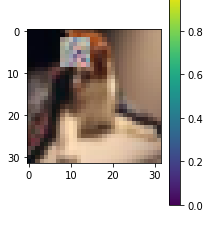

In [77]:
plt.figure(figsize=(3,4))
img = ((img - img.min())/(img.max() - img.min()))
plt.imshow(img)
plt.colorbar()

